# Basic linear regression

## Data processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unittest

from functions import fillna_by_time, Check_fillna_by_time
unittest.main(argv=["", "Check_fillna_by_time"], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.008s

OK


In [2]:
building_info = pd.read_csv('.\data\\building_metadata.csv')
train_meters = pd.read_csv('.\data\\train.csv')
weather_train = pd.read_csv('.\data\\weather_train.csv')

In [3]:
building_info.head(3)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN


In [4]:
# separate tasks
electricity = train_meters[train_meters.meter==0].drop('meter', axis=1)
chilledwater = train_meters[train_meters.meter==1].drop('meter', axis=1)
steam = train_meters[train_meters.meter==2].drop('meter', axis=1)
hotwater = train_meters[train_meters.meter==3].drop('meter', axis=1)

del train_meters

In [5]:
# let's start with electricity
# we should join dataframes to see the whole picture
electricity = electricity.set_index('building_id').join(
    building_info.set_index('building_id'), 
    on='building_id')
electricity.set_index(pd.Index([i for i in range(len(electricity))]), inplace=True)

In [6]:
# remove nans
electricity['floor_count'].fillna(electricity['floor_count'].median(), inplace=True)
electricity['year_built'].fillna(electricity['year_built'].median(), inplace=True)

In [7]:
for i in electricity.columns:
    part = 'has Nans!!!' if electricity[i].isna().any() else 'doesn\'t have Nans'
    print(f'column {i} {part}')

column timestamp doesn't have Nans
column meter_reading doesn't have Nans
column site_id doesn't have Nans
column primary_use doesn't have Nans
column square_feet doesn't have Nans
column year_built doesn't have Nans
column floor_count doesn't have Nans


In [8]:
print('There are', len(weather_train['site_id'].unique()), 'unique site_ids')

mean_for_site_id = 0
for i in weather_train['site_id'].unique():
    mean_for_site_id += weather_train['site_id'][weather_train['site_id'] == i].count()
mean_for_site_id /= len(weather_train['site_id'].unique())

print('But for every site_id there are in average', int(mean_for_site_id), 'rows')
print('We are going to have', int(mean_for_site_id)*len(electricity),'raws at all!!!')

There are 16 unique site_ids
But for every site_id there are in average 8735 rows
We are going to have 105352048850 raws at all!!!


In [9]:
for index in weather_train['site_id'].unique():
    testing_site_id = weather_train[weather_train['site_id'] == index]
    
    with_nans = testing_site_id['air_temperature'].isna()
    for i in testing_site_id.columns:
        with_nans |= testing_site_id[i].isna()

    print('for', index, len(testing_site_id[~with_nans])/len(testing_site_id), 
          'of data doesn\'t have Nans at all')

for 0 0.5429189435336976 of data doesn't have Nans at all
for 1 0.0 of data doesn't have Nans at all
for 2 0.6747125128088353 of data doesn't have Nans at all
for 3 0.5714123006833713 of data doesn't have Nans at all
for 4 0.4361835363770921 of data doesn't have Nans at all
for 5 0.0 of data doesn't have Nans at all
for 6 0.5867683898884081 of data doesn't have Nans at all
for 7 0.0 of data doesn't have Nans at all
for 8 0.5429189435336976 of data doesn't have Nans at all
for 9 0.44123006833712985 of data doesn't have Nans at all
for 10 0.666021407424277 of data doesn't have Nans at all
for 11 0.0 of data doesn't have Nans at all
for 12 0.0 of data doesn't have Nans at all
for 13 0.49379483092337473 of data doesn't have Nans at all
for 14 0.5924575595305913 of data doesn't have Nans at all
for 15 0.006505796072864916 of data doesn't have Nans at all


In [13]:
testing_site_id = weather_train[weather_train['site_id'] == 0].drop('site_id', axis=1)
testing_site_id.head(3)

,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0


In [14]:
fillna_by_time(testing_site_id, 'cloud_coverage').head(3)

,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,2016-01-01 01:00:00,24.4,6.0,21.1,-1.0,1020.2,70.0,1.5
2,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0


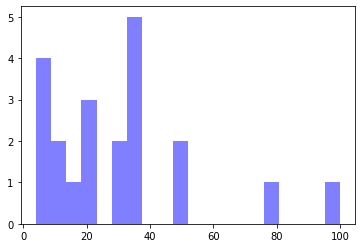

In [78]:
# research features for each site_id

# for site_id = 1

#UNFINISHED
x = [21,22,23,4,5,6,77,8,9,10,31,32,33,34,35,36,37,18,49,50,100]
num_bins = 20
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [ ]:
# our regression should understand where to put zeros
# (they appear quite often)